In [2]:
import numpy as np
import matplotlib.pyplot as plt
import illustris_python.groupcat as gc
from sklearn.neighbors import NearestNeighbors
%matplotlib inline

In [3]:
def load_summary(snap_name, boxsize=75000.0):
    dtype=[('fofid','i8'),
           ('mfof', 'f8'),
           ('x', 'f8'),
           ('y', 'f8'), 
           ('z', 'f8'),
           ('vx', 'f8'),
           ('vy', 'f8'),
           ('vz', 'f8')]
    snap_data = np.loadtxt(snap_name, dtype=dtype)    
    return snap_data

In [8]:
data_dm_A = load_summary('../data/dm_selected/summary_halo_A.txt')
data_dm_B = load_summary('../data/dm_selected/summary_halo_B.txt')
data_mstar_A = load_summary('../data/mstar_selected/summary_halo_A.txt')
data_mstar_B = load_summary('../data/mstar_selected/summary_halo_B.txt')
hubble = 0.704

In [15]:
def norm_pos(data_A):
    d = 0.0
    for c in ['x', 'y', 'z']:
        d += data_A[c]**2
    return np.sqrt(d)
def separation(data_A, data_B):
    d = 0.0
    for c in ['x', 'y', 'z']:
        d += (data_A[c] - data_B[c])**2
    d = np.sqrt(d)
    return d
def vel_diff(data_A, data_B):
    d = 0.0
    for c in ['x', 'y', 'z']:
        d += (data_A['v'+c] - data_B['v'+c])**2
    d = np.sqrt(d)
    return d
def vel_radial(data_A, data_B):
    d = 0.0
    dd = separation(data_A, data_B) 
    for c in ['x', 'y', 'z']:
        d += (data_B['v'+c] - data_A['v'+c])*(data_B[c] - data_A[c])/dd
        # this term corresponds to the Hubble Flow
        d += (data_B[c] - data_A[c]) * 100.0/1000.0
    return d
def vel_tangential(data_A, data_B):
    dd = separation(data_A, data_B) 
    v_rad = {}
    v_tan = {}
    for c in ['x', 'y', 'z']:
        v_rad[c] = (data_B['v'+c] - data_A['v'+c])*(data_B[c] - data_A[c])/dd
        v_tan[c] = (data_B['v'+c] - data_A['v'+c]) - v_rad[c]
    vel_tan = norm_pos(v_tan)
    return vel_tan
def total_mass(data_A, data_B):
    t = data_A['mfof'] + data_B['mfof']
    same = (data_A['fofid']==data_B['fofid'])
    t[same] = data_A['fofid'][same]
    return t

def dump_subvolume(subhalos, id_list, offset, boxsize, file_id=1, base_filename="test", out_dir="../data/", hubble=0.704):
    filename = "%s/%s_%d.dat"%(out_dir, base_filename, file_id)
    out =  open(filename, "w")
    n_points = np.size(id_list)
    tmp_pos = subhalos['SubhaloPos']
    tmp_mags = subhalos['SubhaloStellarPhotometrics']
    tmp_vel = subhalos['SubhaloVel']
    tmp_vmax = subhalos['SubhaloVmax']
    tmp_group_number = subhalos['SubhaloGrNr']
    tmp_subhalo_masses = subhalos['SubhaloMassType']
    tmp_subhalo_stellar_mass = tmp_subhalo_masses[:,4]
    out.write("#subID\t subGroupNr x\t y\t z\t vx\t yv\t yz\t vmax\t B_MAG V_MAG M_star\n")
    out.write("#subID\t groupID\t kpc\t kpc\t kpc\t km/s\t km/s\t km/s\t km/s\t mags mags 10^10Msun\n")
    for i in range(n_points):
        ii = id_list[i]
        out.write("%d %d %f %f %f %f %f %f %f %e %e %e\n"%(ii, tmp_group_number[ii],
                                                    tmp_pos[ii,0]/hubble, tmp_pos[ii,1]/hubble, tmp_pos[ii,2]/hubble, 
                                                       tmp_vel[ii,0], tmp_vel[ii,1], tmp_vel[ii,2],
                                                       tmp_vmax[ii], tmp_mags[ii,1], tmp_mags[ii,2],
                                                       tmp_subhalo_stellar_mass[ii]/hubble))

In [6]:
d_dm = separation(data_dm_A, data_dm_B)
d_mstar = separation(data_mstar_A, data_mstar_B)
v_dm = vel_diff(data_dm_A, data_dm_B)
v_mstar = vel_diff(data_mstar_A, data_mstar_B)
v_radial_dm = vel_radial(data_dm_A, data_dm_B)
v_radial_mstar = vel_radial(data_mstar_A, data_mstar_B)
v_tan_dm = vel_tangential(data_dm_A, data_dm_B)
v_tan_mstar = vel_tangential(data_mstar_A, data_mstar_B)
t_dm = total_mass(data_dm_A, data_dm_B)
t_mstar = total_mass(data_mstar_A, data_mstar_B)

In [9]:
selection_mstar = (v_radial_mstar < 0.0) & (v_radial_mstar > -120.0) & (v_tan_mstar<80.0) & (d_mstar/hubble < 1500)

In [10]:
basePath = "/hpcfs/home/ciencias/fisica/docentes/je.forero/Illustris-1/"
halo_fields = ['GroupFirstSub', 'Group_M_Crit200', 'Group_R_Crit200', 'Group_M_Mean200',
               'GroupNsubs', 'GroupPos', 'GroupVel', 'GroupFirstSub', 'GroupMassType']
halos = gc.loadHalos(basePath,135, fields=halo_fields) # the selection is based on the FOF groups

subhalo_fields = ['SubhaloMass','SubhaloSFRinRad', 'SubhaloPos', 'SubhaloVmax','SubhaloMassType',
                  'SubhaloVel', 'SubhaloParent', 'SubhaloGrNr', 'SubhaloStellarPhotometrics']
subhalos = gc.loadSubhalos(basePath,135, fields=subhalo_fields)
header = gc.loadHeader(basePath,135)
BoxSize = header['BoxSize']

In [16]:
in_pair_A = data_mstar_A[selection_mstar]
in_pair_B = data_mstar_B[selection_mstar]
n_pairs = len(in_pair_A)

for i in range(n_pairs):
    center = np.ones(3)
    center[0] = 0.5 * (in_pair_A['x'][i] + in_pair_B['x'][i])
    center[1] = 0.5 * (in_pair_A['y'][i] + in_pair_B['y'][i])
    center[2] = 0.5 * (in_pair_A['z'][i] + in_pair_B['z'][i])

    delta = subhalos['SubhaloPos'].copy()
    delta[:,0] = (delta[:,0] - center[0] + BoxSize/2.0)
    delta[:,1] = (delta[:,1] - center[1] + BoxSize/2.0)
    delta[:,2] = (delta[:,2] - center[2] + BoxSize/2.0)
    delta = delta%BoxSize
    
    norm_delta = np.sqrt(((delta - BoxSize/2.0)**2).sum(1))
    inside = np.where(norm_delta/hubble<2000.0)
    inside = inside[0]
    dump_subvolume(subhalos, inside, (center-BoxSize/2.0), BoxSize, file_id=i, 
                   base_filename="Illustris_group", out_dir="../data/mstar_selected/", hubble=hubble)
    print(i, n_pairs, np.size(inside))

0 27 580
1 27 670
2 27 674
3 27 619
4 27 664
5 27 595
6 27 471
7 27 728
8 27 378
9 27 395
10 27 230
11 27 279
12 27 319
13 27 448
14 27 269
15 27 372
16 27 352
17 27 253
18 27 395
19 27 236
20 27 271
21 27 471
22 27 331
23 27 349
24 27 388
25 27 430
26 27 376


In [17]:
for i in range(n_pairs):
    data = np.loadtxt("../data/mstar_selected/Illustris_group_%d.dat"%(i))
    vmax = data[:,8]
    sorted_v_id = np.argsort(vmax)
    host_id = data[:,1]
    hosts_pair = host_id[sorted_v_id[-3:]]
    if hosts_pair[-1]==hosts_pair[-2]:
        print(i, vmax[sorted_v_id[-3:]], hosts_pair)
    

0 [ 102.255219  229.352844  293.188782] [ 306.  306.  306.]
2 [ 106.598167  155.150223  193.144363] [ 9245.   580.   580.]
4 [ 163.928055  183.77124   203.263306] [ 1842.   622.   622.]


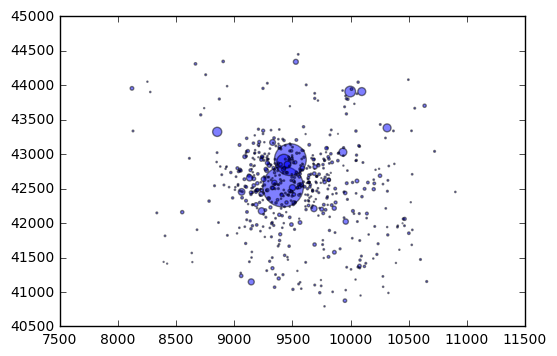

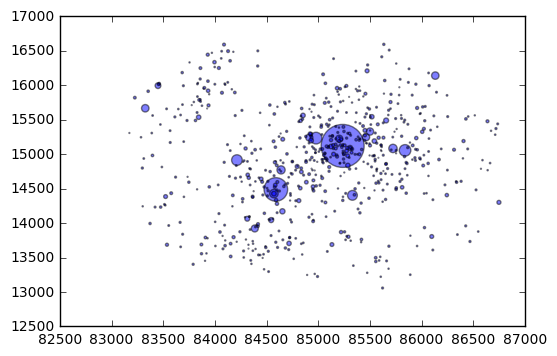

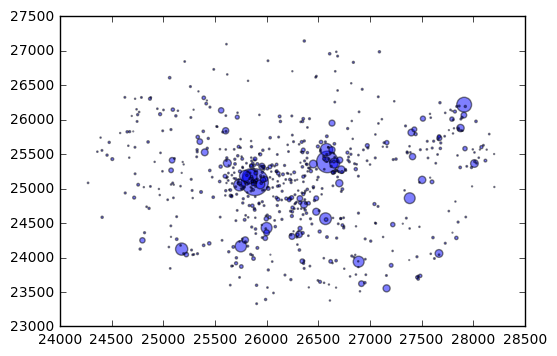

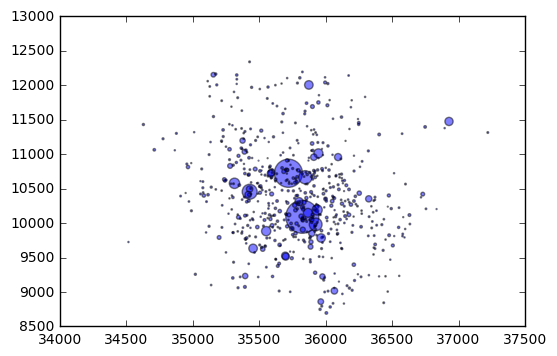

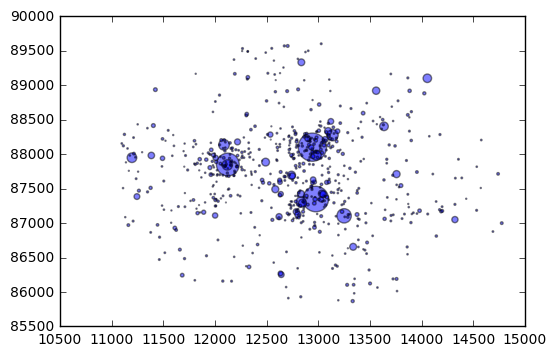

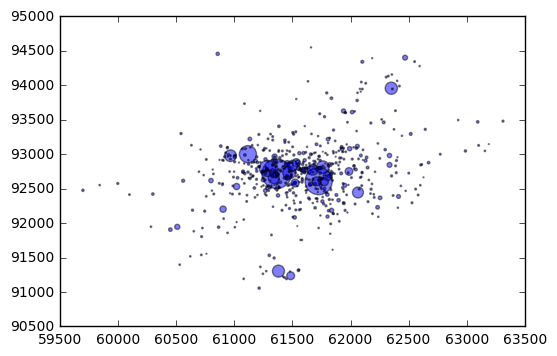

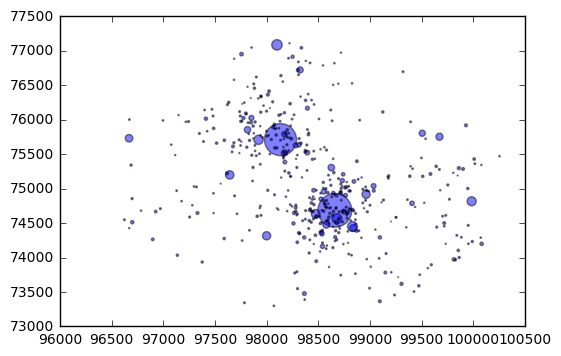

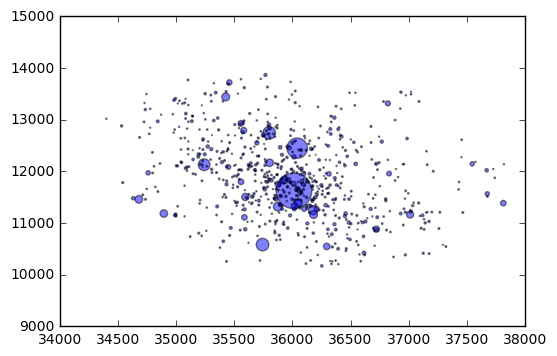

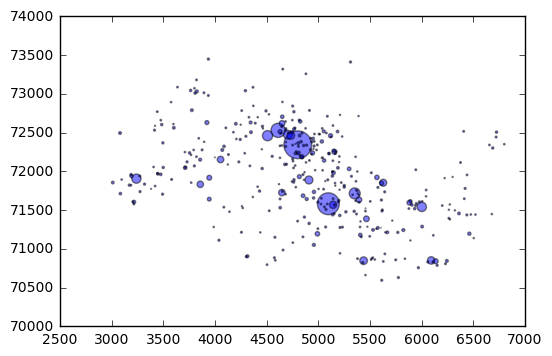

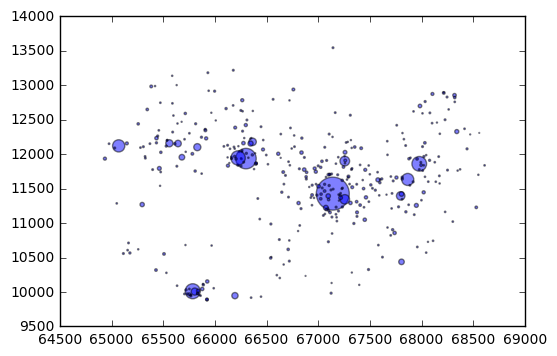

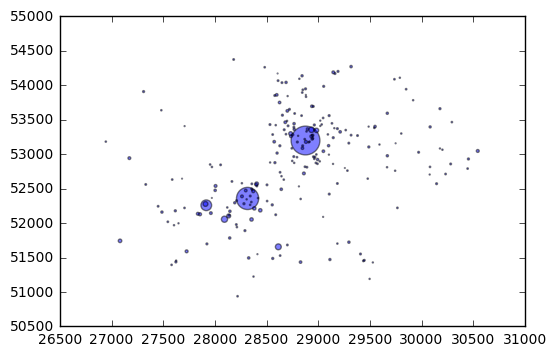

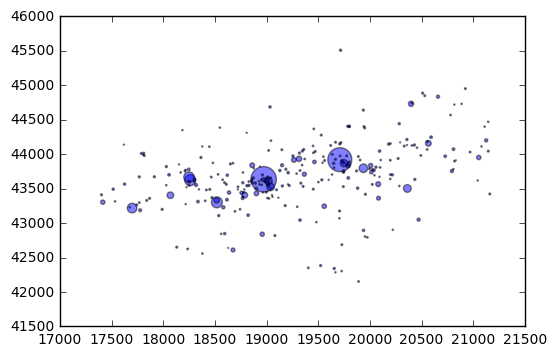

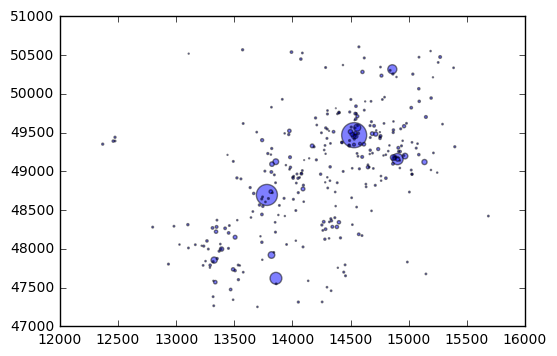

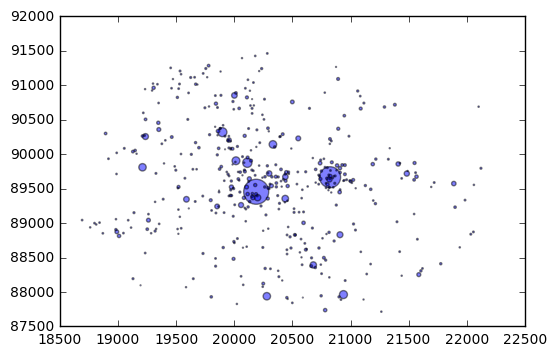

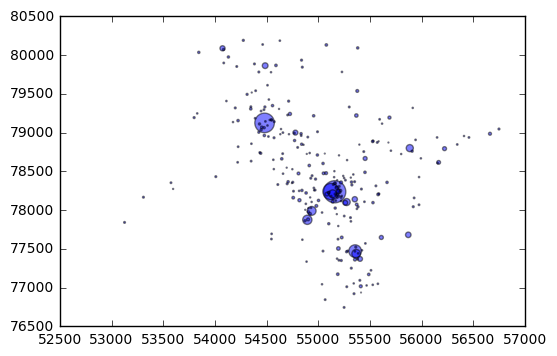

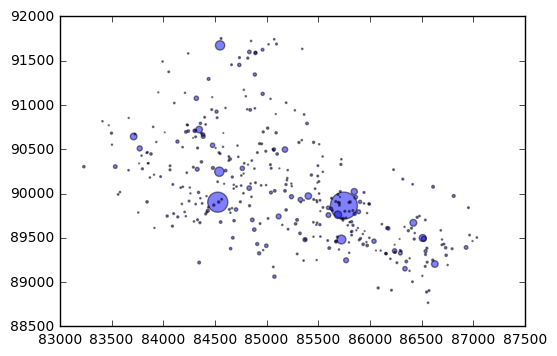

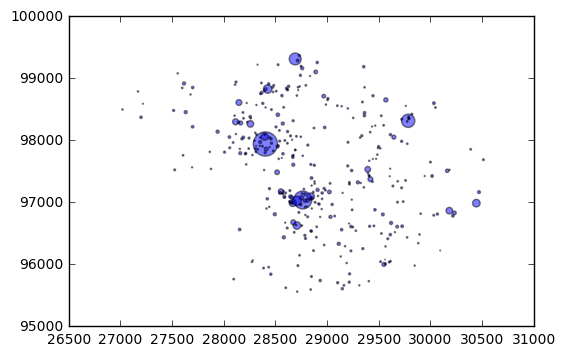

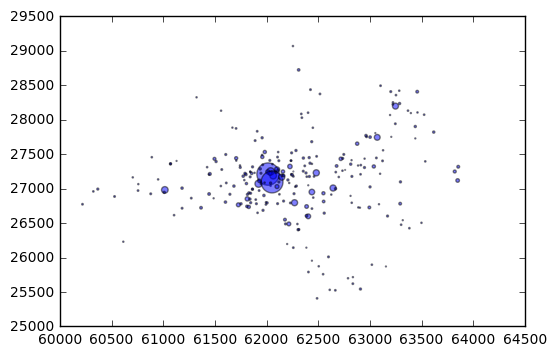

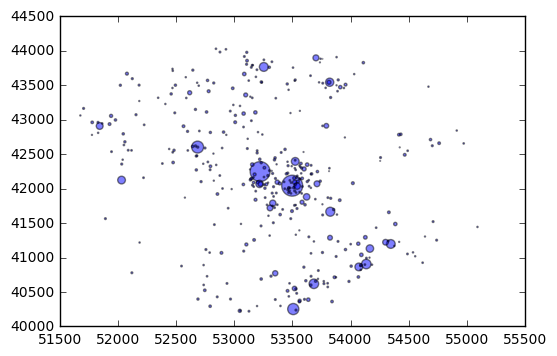

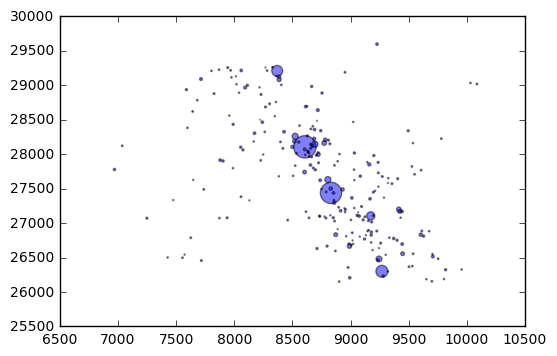

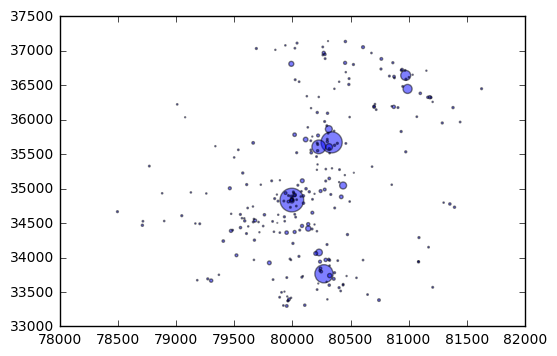

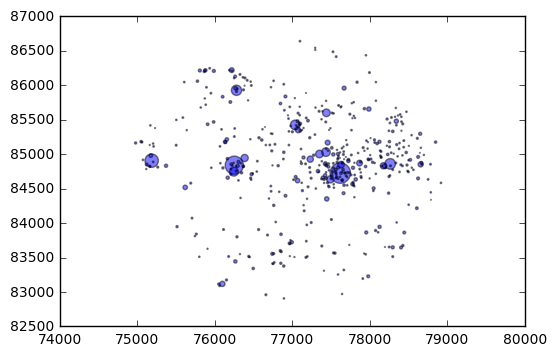

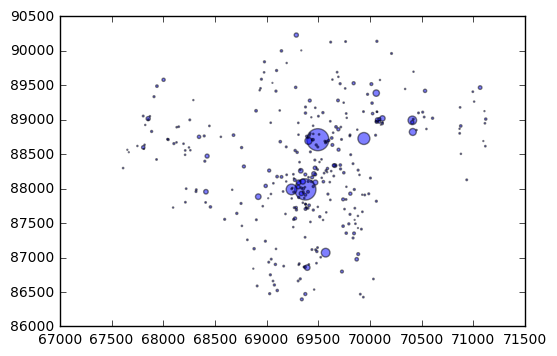

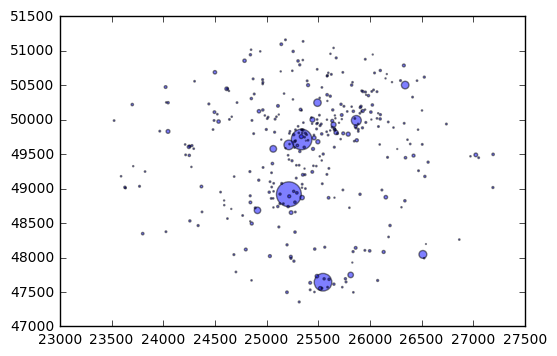

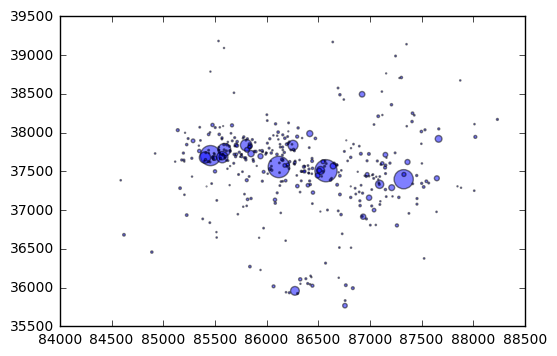

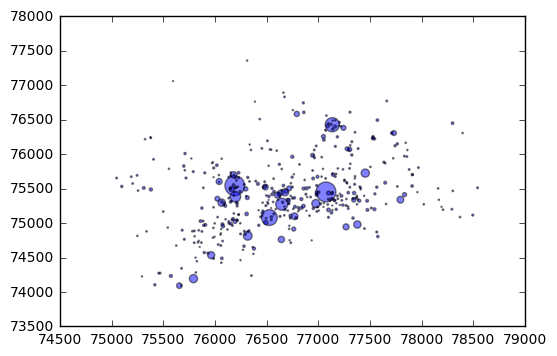

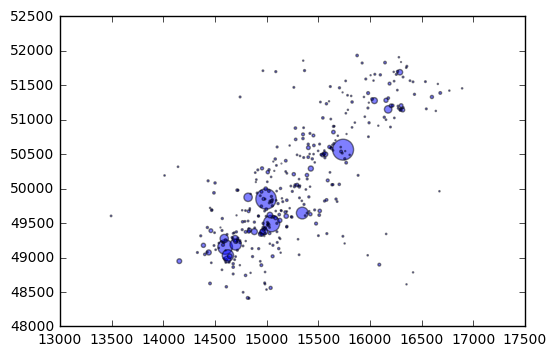

In [18]:
for i in range(n_pairs):
    plt.clf()
    data = np.loadtxt("../data/mstar_selected/Illustris_group_{}.dat".format(i))
    plt.scatter(data[:,2], data[:,3], s=data[:,8]**2/100, alpha=0.5)
    plt.show()